<a href="https://colab.research.google.com/github/peteray-dev/Brain_Tumour_Detection/blob/master/Brain_Tumour_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project - Brain Tumor Classification

# Importing Libraries 📚💻

In [2]:
!pip install tensorflow==2.12.0

INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.0/586.0 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 78.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 76.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 96.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 106.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 MB 14.6 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Unins

In [3]:
!unzip -q "/content/Training_brain.zip" -d "/content/brain"


In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Dropout, Activation , Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import VGG16

import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

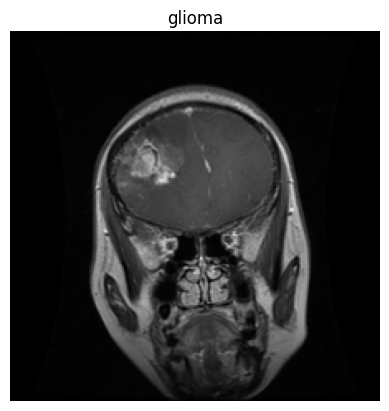

In [4]:
# Load image
img_path = '/content/brain/Training/glioma/Tr-glTr_0000.jpg'
img = Image.open(img_path)
img = img.resize((224, 224))  # Resize to consistent size

# Display image
plt.imshow(img)
plt.title("glioma")
plt.axis('off')  # Hide axis
plt.show()

In [5]:
train_datasets = "/content/brain/Training"
# validation_datasets = "/kaggle/input/brain-tumor-mri-dataset/Testing"

# Image Augmentation + Loading the Data in Batches 📦➗

In [6]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split

def split_train_validation(train_datasets, validation_split=0.2):
    """
    Splits the training dataset into train (80%) and validation (20%) while preserving class labels.

    Args:
        train_datasets (str): Path to the original training dataset folder.
        validation_split (float): Proportion of validation data (default 20%).

    Returns:
        train_path (str): Path to the new training dataset folder.
        val_path (str): Path to the new validation dataset folder.
    """

    # Define new directories for the split dataset
    train_path = os.path.join(train_datasets, "train_split")
    val_path = os.path.join(train_datasets, "val_split")

    # Create directories if they don't exist
    os.makedirs(train_path, exist_ok=True)
    os.makedirs(val_path, exist_ok=True)

    # Loop through each class folder
    for class_folder in os.listdir(train_datasets):
        class_path = os.path.join(train_datasets, class_folder)

        # Skip non-directory entries (in case there are files in train_datasets)
        if not os.path.isdir(class_path):
            continue

        # Get all image files inside the class folder
        images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

        # Skip empty class folders
        if len(images) < 2:
            print(f"⚠️ Skipping '{class_folder}' (Not enough images: {len(images)})")
            continue

        # Split dataset into train (80%) and validation (20%)
        train_images, val_images = train_test_split(images, test_size=validation_split, random_state=42)

        # Create class folders in train_split/ and val_split/
        os.makedirs(os.path.join(train_path, class_folder), exist_ok=True)
        os.makedirs(os.path.join(val_path, class_folder), exist_ok=True)

        # Copy images to train_split/
        for img in train_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(train_path, class_folder, img))

        # Copy images to val_split/
        for img in val_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(val_path, class_folder, img))

        print(f"✅ Split '{class_folder}': {len(train_images)} train, {len(val_images)} validation")

    print("\n🎯 Dataset split completed successfully!")
    return train_path, val_path

# Example usage:
train_datasets = "/content/brain/Training"  # Change this path to your dataset folder
train_path, val_path = split_train_validation(train_datasets)

print(f"\n✅ Training data path: {train_path}")
print(f"✅ Validation data path: {val_path}")


✅ Split 'glioma': 1056 train, 265 validation
✅ Split 'meningioma': 1071 train, 268 validation
✅ Split 'notumor': 1276 train, 319 validation
⚠️ Skipping 'val_split' (Not enough images: 0)
✅ Split 'pituitary': 1165 train, 292 validation
⚠️ Skipping 'train_split' (Not enough images: 0)

🎯 Dataset split completed successfully!

✅ Training data path: /content/brain/Training/train_split
✅ Validation data path: /content/brain/Training/val_split


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 64
image_size = 224

train_datagen = ImageDataGenerator(rescale=1.0/255)
val_datagen = ImageDataGenerator(rescale=1.0/255)

train_data = train_datagen.flow_from_directory(
    directory=train_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode="categorical"
)

val_data = val_datagen.flow_from_directory(
    directory=val_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode="categorical"
)

print("✅ Train & validation datasets are ready!")


Found 4568 images belonging to 4 classes.
Found 1144 images belonging to 4 classes.
✅ Train & validation datasets are ready!


In [8]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def prepare_the_datasets(train_datasets, validation_datasets, batch_size, image_size):
    """
    Prepares training and validation datasets using ImageDataGenerator.

    Args:
        train_datasets (str): Path to training dataset folder.
        validation_datasets (str): Path to validation dataset folder.
        batch_size (int): Batch size.
        image_size (int): Target image size.

    Returns:
        train_datasets_generator_data, validation_datasets_generator_data
    """

    # Define ImageDataGenerators
    train_datasets_generator = ImageDataGenerator(rescale=1.0/255, brightness_range=(0.8, 1.2))
    validation_datasets_generator = ImageDataGenerator(rescale=1.0/255)

    # ✅ Ensure only class folders are used (ignore .ipynb_checkpoints and val_split)
    allowed_classes = [folder for folder in os.listdir(train_datasets) if os.path.isdir(os.path.join(train_datasets, folder)) and folder not in ['val_split', '.ipynb_checkpoints']]
    print(f"✅ Allowed Train Classes: {allowed_classes}")

    allowed_classes_val = [folder for folder in os.listdir(validation_datasets) if os.path.isdir(os.path.join(validation_datasets, folder)) and folder not in ['train_split', '.ipynb_checkpoints']]
    print(f"✅ Allowed Validation Classes: {allowed_classes_val}")

    train_datasets_generator_data = train_datasets_generator.flow_from_directory(
        batch_size=batch_size,
        directory=train_datasets,
        shuffle=True,
        target_size=(image_size, image_size),
        class_mode="categorical",
        classes=allowed_classes  # ✅ Explicitly specify classes to avoid unwanted folders
    )

    validation_datasets_generator_data = validation_datasets_generator.flow_from_directory(
        batch_size=batch_size,
        directory=validation_datasets,
        shuffle=True,
        target_size=(image_size, image_size),
        class_mode="categorical",
        classes=allowed_classes_val  # ✅ Explicitly specify classes to avoid unwanted folders
    )

    return train_datasets_generator_data, validation_datasets_generator_data


In [9]:
train_data, validation_data = prepare_the_datasets(
    train_datasets="/content/brain/Training/train_split",
    validation_datasets="/content/brain/Training/val_split",
    batch_size=64,
    image_size=224
)


✅ Allowed Train Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
✅ Allowed Validation Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Found 4568 images belonging to 4 classes.
Found 1144 images belonging to 4 classes.


In [10]:
validation_data.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [11]:
# print(val_path)

![](http://storage.googleapis.com/lds-media/images/vgg16-architecture.width-1200.jpg)


In [12]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

# Transfer Learning Without FineTunning 🏗️🧠

In [13]:
# Load pre-trained VGG16 model without the top layers (include_top=False) 🏗️
conv_base = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the pre-trained layers to prevent training (transfer learning without fine-tuning) ❄️
conv_base.trainable = False

# Build a new model on top of the pre-trained base 🧱
model = Sequential()

# Add the pre-trained VGG16 base model
model.add(conv_base)

# Flatten the output for fully connected layers
model.add(Flatten())

# Add a dense layer with ReLU activation
model.add(Dense(256, activation='relu'))

# Add output layer with softmax activation for 4 classes
model.add(Dense(4, activation='softmax'))

# Compile the model with Adam optimizer and categorical crossentropy loss 🛠️
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


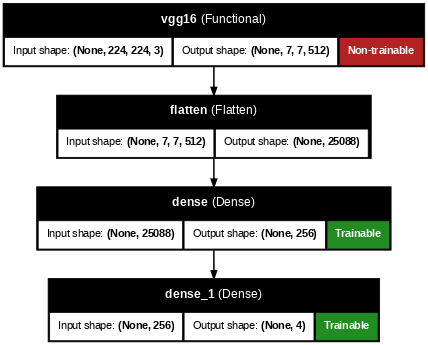

In [14]:
plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    dpi=55,
    show_trainable=True
)

In [15]:
print(f"Train Samples: {train_data.samples}")
print(f"Validation Samples: {validation_data.samples}")


Train Samples: 4568
Validation Samples: 1144


In [16]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [17]:
# Parameters
steps = int(train_data.samples / batch_size)  # Steps per epoch
epochs = 10

# Train the model
history = model.fit(train_data, validation_data = validation_data ,
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 71s 728ms/step - accuracy: 0.6069 - loss: 2.8734 - val_accuracy: 0.8610 - val_loss: 0.3302
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.8906 - loss: 0.2651 - val_accuracy: 0.8846 - val_loss: 0.3016
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 27s 372ms/step - accuracy: 0.8993 - loss: 0.2687 - val_accuracy: 0.9082 - val_loss: 0.2342
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.9062 - loss: 0.1754 - val_accuracy: 0.9170 - val_loss: 0.2267
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 28s 394ms/step - accuracy: 0.9406 - loss: 0.1755 - val_accuracy: 0.9213 - val_loss: 0.2084
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.9531 - loss: 0.1363 - val_accuracy: 0.9274 - val_loss: 0.1918
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 27s 378ms/step - accuracy: 0.9608 - loss: 0.1274 - val_accuracy: 0.9414 - val_loss: 0.1643
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.9531 - loss: 0.1148 - val_accuracy: 0.

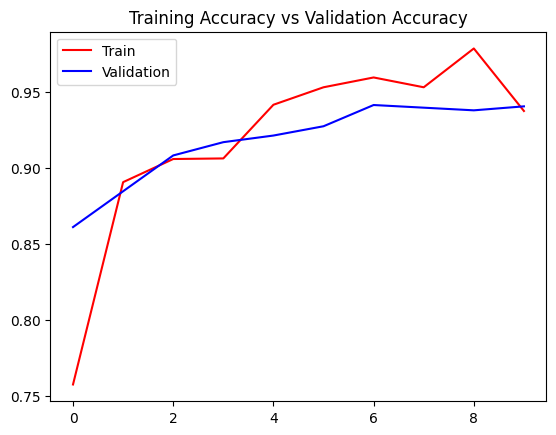

In [19]:
# Plotting the graph of Accuracy and Validation Accuracy
plt.title('Training Accuracy vs Validation Accuracy')

plt.plot(history.history['accuracy'], color='red',label='Train')
plt.plot(history.history['val_accuracy'], color='blue',label='Validation')

plt.legend()

# Transfer Learning With FineTunning 🔄🧠


**The base_model consists of 13 convolutional layers and 5 max-pooling layers (totaling 18 layers in the convolutional base).freezing 15 layers and unfreezing 3 layers for fine-tuning.**

In [20]:

# Load VGG16 model
base_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze layers of base model
for layer in base_model.layers:
    layer.trainable = False

# Optionally unfreeze layers of a specific block (fine-tuning)
for layer in base_model.layers:
    if layer.name.startswith('block5'):
        layer.trainable = True

# Build the model
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)  # Base model in inference mode
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(4, activation='softmax')(x)

model1 = Model(inputs, outputs)

# Compile model
model1.compile(optimizer=Adam(learning_rate=0.0001), # While Finetunning value of learning rate should be small
              loss='categorical_crossentropy',
              metrics=['accuracy'])


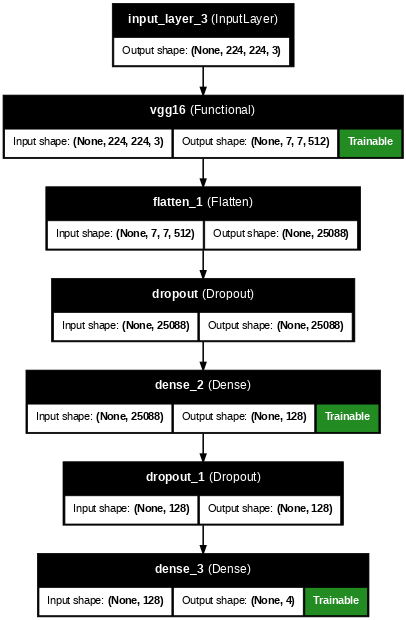

In [21]:
plot_model(
    model1,
    to_file='model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    dpi=55,
    show_layer_activations=False,
    show_trainable=True
)

In [22]:
# Parameters
steps = int(train_data.samples / batch_size)  # Steps per epoch
epochs = 10

# Train the model
history = model1.fit(train_data, validation_data = validation_data ,
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 45s 516ms/step - accuracy: 0.7096 - loss: 0.7295 - val_accuracy: 0.9100 - val_loss: 0.2331
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.9688 - loss: 0.1201 - val_accuracy: 0.9178 - val_loss: 0.2113
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 31s 432ms/step - accuracy: 0.9350 - loss: 0.1830 - val_accuracy: 0.9502 - val_loss: 0.1579
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.9688 - loss: 0.1260 - val_accuracy: 0.9467 - val_loss: 0.1577
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 31s 431ms/step - accuracy: 0.9565 - loss: 0.1186 - val_accuracy: 0.9580 - val_loss: 0.1348
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.9688 - loss: 0.1262 - val_accuracy: 0.9528 - val_loss: 0.1340
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 31s 436ms/step - accuracy: 0.9662 - loss: 0.0909 - val_accuracy: 0.9510 - val_loss: 0.1557
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.9688 - loss: 0.0966 - val_accuracy: 0.

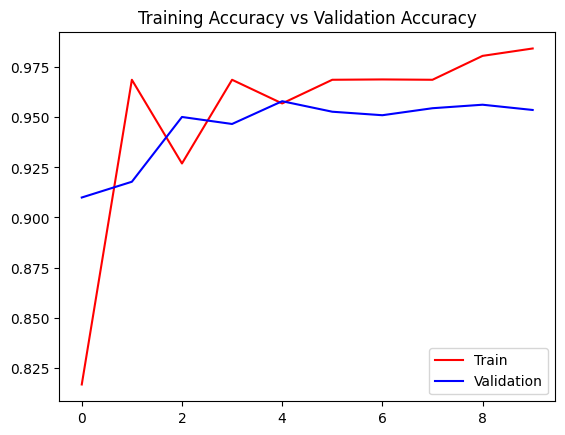

In [23]:
# Plotting the graph of Accuracy and Validation Accuracy
plt.title('Training Accuracy vs Validation Accuracy')

plt.plot(history.history['accuracy'], color='red',label='Train')
plt.plot(history.history['val_accuracy'], color='blue',label='Validation')

plt.legend()

# Saving The model 💾📥

In [24]:
model.save('model.h5')
model1.save('model1.h5')